In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import pytesseract

matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

images_path = './Images/'
images_path_english = './Images/English/'
images_path_japanese = './Images/Japanese/'


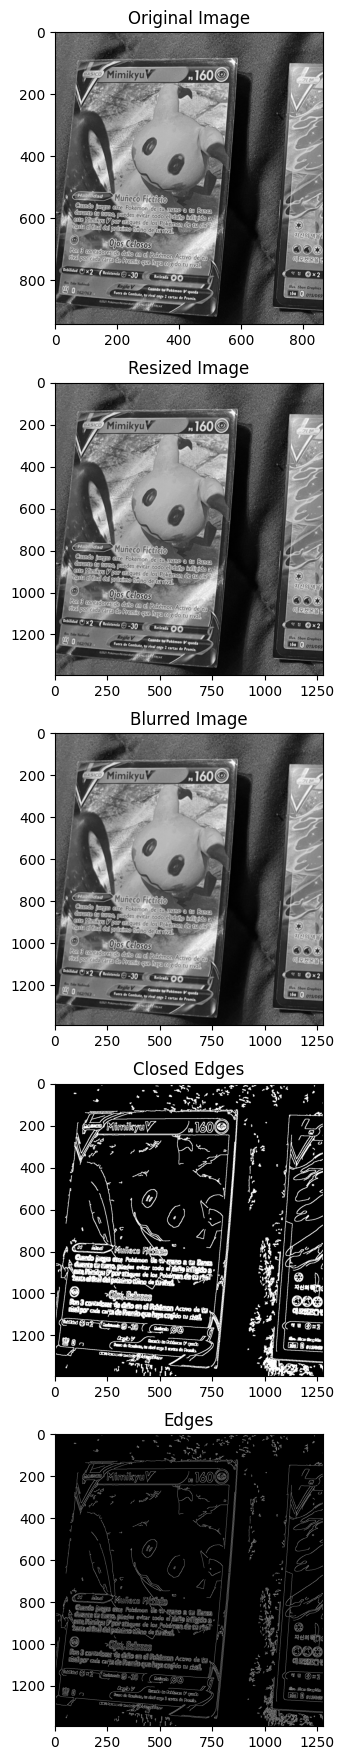

In [3]:
base_image = cv2.imread(images_path_english + 'English_17.jpg',0)
img_resized = cv2.resize(base_image, (1280, int(base_image.shape[0] * 1280/base_image.shape[1])))  # para trabajar siempre a escala similar
img_blur = cv2.GaussianBlur(img_resized, (5,5), 1.0)
edges = cv2.Canny(img_blur, 75, 200)
kernel = np.ones((3,3), np.uint8)
edges_closed = cv2.dilate(edges, kernel, iterations=1)
cnts, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)


plt.figure(figsize=(25, 22))  # (ancho, alto) en pulgadas

plt.subplot(5, 1, 1)
plt.imshow(base_image, cmap='gray')
plt.title('Original Image')

plt.subplot(5, 1, 2)
plt.imshow(img_resized, cmap='gray')
plt.title('Resized Image')

plt.subplot(5, 1, 3)
plt.imshow(img_blur, cmap='gray')
plt.title('Blurred Image')

plt.subplot(5, 1, 4)
plt.imshow(edges_closed, cmap='gray')
plt.title('Closed Edges')

plt.subplot(5, 1, 5)
plt.imshow(edges, cmap='gray')
plt.title('Edges')

plt.show()


In [4]:
import cv2
import numpy as np
import pytesseract


# ------------------------------------------------------------------
# 2.1 y 2.2 (rápido): cargar y preprocesar
# ------------------------------------------------------------------
def cargar_y_preprocesar(ruta_img, ancho_max=1280):
    img = cv2.imread(ruta_img)
    if img is None:
        raise ValueError("No se pudo leer la imagen. Revisa la ruta.")

    h, w = img.shape[:2]
    if w > ancho_max:
        escala = ancho_max / w
        img = cv2.resize(img, (ancho_max, int(h * escala)))

    img_blur = cv2.GaussianBlur(img, (5, 5), 1.0)
    img_gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(img_gray, 75, 200)
    mostrar_redimensionada("1", edges)


    kernel = np.ones((3, 3), np.uint8)
    # ensancha
    edges = cv2.dilate(edges, kernel, iterations=2)
    mostrar_redimensionada("2", edges)

    # cierra huecos para que el borde de la carta sea una sola pieza
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)

    mostrar_redimensionada("3", edges)


    return img, img_gray, edges


# ------------------------------------------------------------------
# 2.3: encontrar el contorno de la carta (cuadrilátero grande)
# ------------------------------------------------------------------
def encontrar_carta_como_quad(edges,
                              margen_borde=6,
                              aspect_min=0.5,
                              aspect_max=0.9):
    """
    Busca la carta tomando SOLO el contorno externo más grande
    que no toque el borde de la imagen.
    """
    h, w = edges.shape[:2]

    # SOLO externos → así no nos quedamos con el cuadro de ataques
    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    candidatos = []

    for c in cnts:
        area = cv2.contourArea(c)
        if area < 1000:   # ruido
            continue

        pts = c.reshape(-1, 2)
        # descartar lo que toca los bordes de la imagen (mano, funda, borde foto)
        if (
            np.any(pts[:, 0] <= margen_borde)
            or np.any(pts[:, 1] <= margen_borde)
            or np.any(pts[:, 0] >= w - margen_borde)
            or np.any(pts[:, 1] >= h - margen_borde)
        ):
            continue

        rect = cv2.minAreaRect(c)
        (wr, hr) = rect[1]
        if wr == 0 or hr == 0:
            continue

        ar = min(wr, hr) / max(wr, hr)
        candidatos.append((area, ar, rect))

    if not candidatos:
        return None

    # nos quedamos con el de mayor área
    candidatos.sort(key=lambda x: x[0], reverse=True)
    area, ar, rect = candidatos[0]

    # si quieres puedes filtrar por aspecto, pero amplio
    if not (aspect_min <= ar <= aspect_max):
        # aún así devolvemos, porque es lo mejor que hay
        pass

    box = cv2.boxPoints(rect)
    return box.astype(np.float32)





# ------------------------------------------------------------------
# 2.4: ordenar puntos y aplicar homografía (rectificar)
# ------------------------------------------------------------------
def ordenar_puntos(pts):
    """
    Recibe 4 puntos desordenados y devuelve:
    [top-left, top-right, bottom-right, bottom-left]
    """
    # Asegurar que pts es un numpy array
    pts = np.array(pts, dtype=np.float32)

    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left

    return rect


def rectificar_carta(img_color, pts_src, ancho_dest=720):
    """
    pts_src: 4 puntos de la carta en la imagen original
    """
    # relación de la carta Pokémon aprox 63x88 -> 0.715
    ratio = 0.715
    alto_dest = int(ancho_dest / ratio)

    rect = ordenar_puntos(pts_src)
    dst = np.array(
        [
            [0, 0],
            [ancho_dest - 1, 0],
            [ancho_dest - 1, alto_dest - 1],
            [0, alto_dest - 1],
        ],
        dtype="float32",
    )

    H, _ = cv2.findHomography(rect, dst)
    warped = cv2.warpPerspective(img_color, H, (ancho_dest, alto_dest))

    return warped


# ------------------------------------------------------------------
# 2.5: extraer ROIs dentro de la carta ya rectificada
# (los números son aproximados, ajusta viendo una carta rectificada)
# ------------------------------------------------------------------
def extraer_rois(carta_rectificada):
    h, w = carta_rectificada.shape[:2]

    # arriba suele ir nombre y HP. Ajusta a ojo:
    # nombre: parte superior izquierda
    name_roi = carta_rectificada[
        int(0.035 * h) : int(0.12 * h), int(0.08 * w) : int(0.55 * w)
    ]
    # HP: parte superior derecha
    hp_roi = carta_rectificada[
        int(0.035 * h) : int(0.12 * h), int(0.60 * w) : int(0.90 * w)
    ]
    # texto inferior (ataques / descripción)
    text_roi = carta_rectificada[
        int(0.40 * h) : int(0.85 * h), int(0.07 * w) : int(0.93 * w)
    ]

    return {"name": name_roi, "hp": hp_roi, "text": text_roi}


# ------------------------------------------------------------------
# 2.6: preparar cada ROI para OCR
# ------------------------------------------------------------------
def preparar_para_ocr(roi_bgr):
    gray = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2GRAY)
    # a veces hay ruido de impresión, probamos con blur ligero
    gray = cv2.medianBlur(gray, 3)

    # umbral adaptativo para lidiar con reflejos
    bin_img = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    # opcional: pequeña apertura para limpiar
    kernel = np.ones((2, 2), np.uint8)
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel)

    return bin_img


# ------------------------------------------------------------------
# 2.6 (continuación): OCR
# ------------------------------------------------------------------
def ocr_roi(img_bin, psm=7):
    """
    psm=7 -> trata el ROI como una línea de texto
    """
    config = f"--oem 3 --psm {psm}"
    text = pytesseract.image_to_string(
        img_bin, config=config, lang="eng"
    )  # o 'spa' si quieres español
    # limpiamos un poco
    text = text.strip()
    return text

def mostrar_redimensionada(win_name, img, ancho_max=900, alto_max=700):
    h, w = img.shape[:2]
    escala = min(ancho_max / w, alto_max / h, 1.0)  # nunca agrandar
    nuevo_w = int(w * escala)
    nuevo_h = int(h * escala)
    img_small = cv2.resize(img, (nuevo_w, nuevo_h))
    cv2.imshow(win_name, img_small)

# ------------------------------------------------------------------
# Demo / flujo completo
# ------------------------------------------------------------------
if __name__ == "__main__":
    ruta = images_path_japanese +"Japanese_6.jpg"
    # 1) preprocesar
    img_color, img_gray, edges = cargar_y_preprocesar(ruta)

    # 2) encontrar carta
    quad = encontrar_carta_como_quad(edges)
    if quad is None:
        print("No se encontró una carta con forma cuadrilátera adecuada.")
    else:
        img_debug = img_color.copy()
        quad_int = quad.astype(int)
        cv2.polylines(img_debug, [quad_int], True, (0, 255, 0), 3)
        mostrar_redimensionada("debug", img_debug)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
import pytesseract  # opcional si luego OCR


# ------------------------------------------------------------
# 1. Cargar y preprocesar
# ------------------------------------------------------------
def cargar_y_preprocesar(ruta_img, ancho_max=1280):
    img = cv2.imread(ruta_img)
    if img is None:
        raise ValueError("No se pudo leer la imagen. Revisa la ruta.")

    h, w = img.shape[:2]
    if w > ancho_max:
        escala = ancho_max / w
        img = cv2.resize(img, (ancho_max, int(h * escala)))

    img_blur = cv2.GaussianBlur(img, (5, 5), 1.0)
    img_gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(img_gray, 75, 200)

    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=2)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

    return img, img_gray, edges


# ------------------------------------------------------------
# 2A. Hough
# ------------------------------------------------------------
def detectar_carta_hough(edges, min_long_linea=200):
    h, w = edges.shape[:2]

    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        threshold=80,
        minLineLength=min_long_linea,
        maxLineGap=20
    )

    if lines is None:
        return None

    lines = lines.reshape(-1, 4)

    verticales = []
    horizontales = []

    for x1, y1, x2, y2 in lines:
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0:
            verticales.append((x1, y1, x2, y2))
            continue

        m = dy / (dx + 1e-6)
        if abs(m) < 0.3:
            horizontales.append((x1, y1, x2, y2))
        elif abs(m) > 3:
            verticales.append((x1, y1, x2, y2))

    if len(verticales) < 2 or len(horizontales) < 2:
        return None

    verticales.sort(key=lambda l: (l[0] + l[2]) / 2)
    v_left = verticales[0]
    v_right = verticales[-1]

    horizontales.sort(key=lambda l: (l[1] + l[3]) / 2)
    h_top = horizontales[0]
    h_bottom = horizontales[-1]

    def interseccion(l1, l2):
        x1, y1, x2, y2 = l1
        x3, y3, x4, y4 = l2

        A1 = y2 - y1
        B1 = x1 - x2
        C1 = A1 * x1 + B1 * y1

        A2 = y4 - y3
        B2 = x3 - x4
        C2 = A2 * x3 + B2 * y3

        det = A1 * B2 - A2 * B1
        if abs(det) < 1e-6:
            return None
        x = (B2 * C1 - B1 * C2) / det
        y = (A1 * C2 - A2 * C1) / det
        return np.array([x, y], dtype=np.float32)

    pt_tl = interseccion(v_left, h_top)
    pt_tr = interseccion(v_right, h_top)
    pt_br = interseccion(v_right, h_bottom)
    pt_bl = interseccion(v_left, h_bottom)

    # CORRECCIÓN: verificar cada punto individualmente
    if pt_tl is None or pt_tr is None or pt_br is None or pt_bl is None:
        return None

    return np.array([pt_tl, pt_tr, pt_br, pt_bl], dtype=np.float32)


# ------------------------------------------------------------
# 2B. Contornos (fallback)
# ------------------------------------------------------------
def encontrar_carta_como_quad(edges,
                              margen_borde=6,
                              aspect_min=0.5,
                              aspect_max=0.9):
    h, w = edges.shape[:2]

    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    candidatos = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 1000:
            continue

        pts = c.reshape(-1, 2)
        if (
            np.any(pts[:, 0] <= margen_borde)
            or np.any(pts[:, 1] <= margen_borde)
            or np.any(pts[:, 0] >= w - margen_borde)
            or np.any(pts[:, 1] >= h - margen_borde)
        ):
            continue

        rect = cv2.minAreaRect(c)
        (wr, hr) = rect[1]
        if wr == 0 or hr == 0:
            continue

        ar = min(wr, hr) / max(wr, hr)
        candidatos.append((area, ar, rect))

    if not candidatos:
        return None

    candidatos.sort(key=lambda x: x[0], reverse=True)
    _, ar, rect = candidatos[0]
    box = cv2.boxPoints(rect)
    return box.astype(np.float32)


# ------------------------------------------------------------
# Ordenar y rectificar
# ------------------------------------------------------------
def ordenar_puntos(pts):
    pts = np.array(pts, dtype=np.float32)
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


def rectificar_carta(img_color, pts_src, ancho_dest=720):
    ratio = 0.715
    alto_dest = int(ancho_dest / ratio)

    rect = ordenar_puntos(pts_src)
    dst = np.array(
        [
            [0, 0],
            [ancho_dest - 1, 0],
            [ancho_dest - 1, alto_dest - 1],
            [0, alto_dest - 1],
        ],
        dtype="float32",
    )

    H, _ = cv2.findHomography(rect, dst)
    warped = cv2.warpPerspective(img_color, H, (ancho_dest, alto_dest))
    return warped


# ------------------------------------------------------------
# Mostrar reducido
# ------------------------------------------------------------
def mostrar_redimensionada(win_name, img, ancho_max=900, alto_max=700):
    h, w = img.shape[:2]
    escala = min(ancho_max / w, alto_max / h, 1.0)
    img_small = cv2.resize(img, (int(w * escala), int(h * escala)))
    cv2.imshow(win_name, img_small)


# ------------------------------------------------------------
# Demo
# ------------------------------------------------------------
if __name__ == "__main__":
    ruta = images_path_english + "English_5.jpg"

    img_color, img_gray, edges = cargar_y_preprocesar(ruta)

    # 1) detección por Hough
    quad_hough = detectar_carta_hough(edges)

    # 2) detección por contornos
    quad_cnt = encontrar_carta_como_quad(edges)

    # --- dibujar hough ---
    img_hough = img_color.copy()
    if quad_hough is not None:
        cv2.polylines(img_hough, [quad_hough.astype(int)], True, (0, 255, 0), 3)
    else:
        cv2.putText(img_hough, "Hough no encontro carta", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

    # --- dibujar contornos ---
    img_cnt = img_color.copy()
    if quad_cnt is not None:
        cv2.polylines(img_cnt, [quad_cnt.astype(int)], True, (255, 0, 0), 3)
    else:
        cv2.putText(img_cnt, "Contornos no encontro carta", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

    # mostrar ambas
    mostrar_redimensionada("Hough", img_hough)
    mostrar_redimensionada("Contornos", img_cnt)

    # si quieres, también rectificar la de Hough si existe,
    # si no, la de contornos
    if quad_hough is not None:
        carta = rectificar_carta(img_color, quad_hough)
        mostrar_redimensionada("Rectificada (Hough)", carta)
    if quad_cnt is not None:
        carta = rectificar_carta(img_color, quad_cnt)
        mostrar_redimensionada("Rectificada (Contorno)", carta)

    cv2.waitKey(0)
    cv2.destroyAllWindows()
